# Imports

In [ ]:
!pip install shap
!pip install lime
!pip install transformers
!pip install gdown

In [1]:
import shap
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# LIME packages
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from lime.lime_text import explanation
from functools import partial
import scipy as sp
from sklearn.utils import check_random_state
from sklearn.metrics import classification_report


from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import word_tokenize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/o

# Downloading the preprocessed data

In [ ]:
!gdown 1-FAL4G--bLerOPdtHWoUb2FelHAc-cRN
!gdown 1-DTIOsUZVbmiGJZMMmLbcSN_NWuqSbql
!gdown 1-8B6g2l8D9U_O370fv6a0O7o_pozyrx0

In [2]:
FILE_PATH = "/kaggle/working/train.pkl"

with open(FILE_PATH, 'rb') as f:
    df_train = pickle.load(f)

In [3]:
FILE_PATH = "/kaggle/working/test.pkl"

with open(FILE_PATH, 'rb') as f:
    df_test = pickle.load(f)

In [4]:
FILE_PATH = "/kaggle/working/val.pkl"

with open(FILE_PATH, 'rb') as f:
    df_val = pickle.load(f)

# Examining the data

In [5]:
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)
df_val.reset_index(drop = True, inplace = True)

In [6]:
df_train.head()

,tweet,label,tweet_with_replaced_emojis,cleaned_data_with_replaced_emojis,Light Stemming
0,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...
1,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
2,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره اجرب اكون ليك اقرب
3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
4,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [7]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(7045, 5)
(1510, 5)
(1510, 5)


In [8]:
label_to_class = [
    'none',
    'anger',
    'joy',
    'sadness',
    'love',
    'sympathy',
    'surprise',
    'fear'
]

In [9]:
label_to_class_dic = {
    0:'none',
    1:'anger',
    2:'joy',
    3:'sadness',
    4:'love',
    5:'sympathy',
    6:'surprise',
    7:'fear'
}

## Embedding parameters

In [29]:
remove_special_tokens=0  #change this to 0 if you want to keep the special token (remove tokens only in naive bayes)
stemtype = 'Light Stemming' #Which stemming type to use

# Embedding

In [11]:
# Downloading the MARBERT model
marbert_model_path = 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(marbert_model_path, from_tf=True)
marbert_model = TFAutoModel.from_pretrained(marbert_model_path, output_hidden_states=True)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at UBC-NLP/MARBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
#Tokenizer function
def bert_tokenize(text: str) -> dict:
  tokens = tokenizer(text, padding='max_length', truncation=True, max_length=50)
  if remove_special_tokens == 1:
    shape = np.array(tokens['input_ids']).shape
    modified_input_ids = np.zeros(shape).astype(np.int32)
    modified_attention_mask = np.zeros(shape).astype(np.int32)
    # Modify the input IDs and attention mask as per your requirement
    for i in range(shape[0]):
      modified_input_ids[i] = [0 if token_id == 1 else 0 if token_id == 3 else 0 if token_id == 0 else 0 if token_id == 2 else 0 if token_id == 4 else token_id for token_id in tokens['input_ids'][i]]
      modified_attention_mask[i] = [0 if token_id in [1, 3, 0, 2, 4] else 1 for token_id in tokens['input_ids'][i]]
    # Update the input IDs and attention mask in the tokens dictionary
    tokens['input_ids'] = modified_input_ids
    tokens['attention_mask'] = modified_attention_mask
  return tokens

In [31]:
#Embedding function
def get_embeddings(ids, mask, type_ids):
  ids = tf.convert_to_tensor(ids)
  mask = tf.convert_to_tensor(mask)
  type_ids = tf.convert_to_tensor(type_ids)
  hidden_states = marbert_model(input_ids=ids, attention_mask=mask, token_type_ids=type_ids)[0]
  averaged_embedding = tf.reduce_mean(hidden_states, axis=1)
  return averaged_embedding.numpy()

In [32]:
#Tokenize the train set
x_train = df_train[stemtype].values.astype(str).tolist()
x_train = bert_tokenize(x_train)

xlen = np.array(x_train['input_ids']).shape[0]

In [33]:
#Embedding the train set in batches of 100
x_train_emb = np.zeros((xlen,768))
for i in range(0,xlen,100):
    if(i+100 < xlen):
        input_ids = x_train['input_ids'][i:i+100]
        attention_mask = x_train['attention_mask'][i:i+100]
        token_type_ids = x_train['token_type_ids'][i:i+100]
        x_train_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
        input_ids = x_train['input_ids'][i:xlen]
        attention_mask = x_train['attention_mask'][i:xlen]
        token_type_ids = x_train['token_type_ids'][i:xlen]
        x_train_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)

In [34]:
#Tokenize the test set
x_test = df_test[stemtype].values.astype(str).tolist()
x_test = bert_tokenize(x_test)

xlen = np.array(x_test['input_ids']).shape[0]

In [35]:
#Embedding the test set in batches of 100
x_test_emb = np.zeros((xlen,768))
for i in range(0,xlen,100):
    if(i+100 < xlen):
        input_ids = x_test['input_ids'][i:i+100]
        attention_mask = x_test['attention_mask'][i:i+100]
        token_type_ids = x_test['token_type_ids'][i:i+100]
        x_test_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
        input_ids = x_test['input_ids'][i:xlen]
        attention_mask = x_test['attention_mask'][i:xlen]
        token_type_ids = x_test['token_type_ids'][i:xlen]
        x_test_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)

## Model

In [42]:
#This is for finding the optimum n_components for PCA
'''
acc = []

for i in range(1,768):
    lda = PCA(n_components=i)
    x_train_emb2 = lda.fit_transform(x_train_emb, df_train['label'])
    x_test_emb2 = lda.transform(x_test_emb)
    log_reg = LogisticRegression(max_iter=10000, multi_class = 'ovr', solver = 'lbfgs', C=1)
    log_reg.fit(x_train_emb2, df_train['label'])
    # test accuracy of light stemmer embeddings
    y_pred = log_reg.predict(x_test_emb2)
    # calculating the accuracy of the classifier
    accuracy = accuracy_score(df_test['label'], y_pred)
    acc.append(accuracy)
'''

In [43]:
#The highest Accuracy
'''
np.max(acc)
'''

0.7185430463576159

In [44]:
#The corresponding n_components for the highest accuracy
'''
np.argmax(acc) + 1
'''

496

Text(0.5, 0, 'Dimensions')

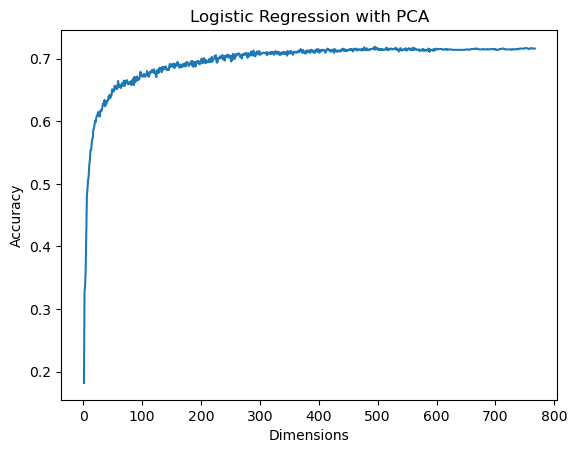

In [45]:
#accuracy vs n_components
'''
ax = sns.lineplot(x = range(1,768), y = acc)
ax.set_title('Logistic Regression with PCA')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dimensions')
'''

In [ ]:
#PCA/LDA are not used with logistic regression
'''
#perform PCA or LDA

#lda = PCA(n_components=44)
lda = LinearDiscriminantAnalysis()
x_train_emb2 = lda.fit_transform(x_train_emb, df_train['label'])
x_test_emb2 = lda.transform(x_test_emb)
'''

In [ ]:
#PCA/LDA are not used with logistic regression
'''
#The percentage of explained data
lda.explained_variance_ratio_.sum()
'''

In [ ]:
#Make the model

log_reg = LogisticRegression(max_iter=10000, multi_class = 'ovr', solver = 'lbfgs', C=1)
#log_reg = GaussianNB(var_smoothing=1e-6)
log_reg.fit(x_train_emb2, df_train['label'])

In [ ]:
# train accuracy of light stemmer embeddings
y_pred_train = log_reg.predict(x_train_emb2)
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_train['label'], y_pred_train)
print("Accuracy:", accuracy)

In [ ]:
# test accuracy of light stemmer embeddings
y_pred = log_reg.predict(x_test_emb2)
# calculating the accuracy of the classifier
accuracy = accuracy_score(df_test['label'], y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(df_train['label'], y_pred_train, target_names = label_to_class))

In [ ]:
print(classification_report(df_test['label'], y_pred, target_names = label_to_class))

In [ ]:
def print_cmatrix(cm)  :
    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(7, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_class, yticklabels=label_to_class)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(df_train['label'], y_pred_train, labels=log_reg.classes_)
print_cmatrix(cm)

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(df_test['label'], y_pred, labels=log_reg.classes_)
print_cmatrix(cm)

In [ ]:
y_true = df_test['label']

# Initilizing LIME and SHAP

## LIME

In [ ]:
def model_predict(text):
  tokens = bert_tokenize(text)
  xlen = np.array(tokens['input_ids']).shape[0]
  x_emb = np.zeros((xlen,768))
  for i in range(0,xlen,100):
    if(i+100 < xlen):
        input_ids = tokens['input_ids'][i:i+100]
        attention_mask = tokens['attention_mask'][i:i+100]
        token_type_ids = tokens['token_type_ids'][i:i+100]
        x_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
        input_ids = tokens['input_ids'][i:xlen]
        attention_mask = tokens['attention_mask'][i:xlen]
        token_type_ids = tokens['token_type_ids'][i:xlen]
        x_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)
        
  x_emb = lda.transform(x_emb)
  return log_reg.predict_proba(x_emb)

In [ ]:
explainer = LimeTextExplainer(class_names=label_to_class)

## SHAP

In [ ]:
def shap_model_predict(text):
  text = text.astype(str).tolist()
  tokens = bert_tokenize(text)
  xlen = np.array(tokens['input_ids']).shape[0]
  x_emb = np.zeros((xlen,768))
  for i in range(0,xlen,100):
    if(i+100 < xlen):
        input_ids = tokens['input_ids'][i:i+100]
        attention_mask = tokens['attention_mask'][i:i+100]
        token_type_ids = tokens['token_type_ids'][i:i+100]
        x_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
        input_ids = tokens['input_ids'][i:xlen]
        attention_mask = tokens['attention_mask'][i:xlen]
        token_type_ids = tokens['token_type_ids'][i:xlen]
        x_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)
        
  x_emb = lda.transform(x_emb)
  return log_reg.predict_proba(x_emb)

In [ ]:
'''
function that initializes shap with the appropriate model
parameters
model: an instance of your model, ex: LogisticRegression instance
'''
def initializeShap(model):
  # split input text into tokens
  masker = shap.maskers.Text(tokenizer=r"\W+")
  explainer = shap.Explainer(shap_model_predict, masker=masker, output_names=label_to_class)
  return explainer

In [ ]:
log_reg_explainer = initializeShap(model=log_reg)

# Save predictions to a CSV file

In [ ]:
def map_label_to_class(indices, classes):
  return [classes[idx] for idx in indices]

In [ ]:
def create_csv(y_pred_idx, y_true_idx, file_path="examples.csv"):
  y_pred, y_true = map_label_to_class(y_pred_idx, label_to_class), map_label_to_class(y_true_idx, label_to_class)
  with open(file_path, 'w') as file:
    file.write('Index,True Label,Predicted Label\n')
    for i in range(len(y_pred)):
      file.write(f'{i},{y_true[i]},{y_pred[i]}\n')
  print("Content has been written to the file.")

In [ ]:
create_csv(y_pred, df_test['label'], file_path="examples.csv")

# Exploration

## loop through all incorrectly classifies examples and exctract the most common words that led to the wrong classfication

In [ ]:
def get_word_frequency(df):
  # creating a dictionary to hold the number of times a specific word occurs
  word_frequency = {}
  for idx in incorrectly_classified:
    # tokenizing the words
    words_to_add = word_tokenize(df.iloc[idx])
    # looping through each word in list
    for word in words_to_add:
      if word in word_frequency:
        word_frequency[word] += 1
      else: word_frequency[word] = 1
  # soring the dictionary from most common words to least common
  sorted_list = sorted(word_frequency.items(), key=lambda word: word[1], reverse=True)
  return sorted_list

In [ ]:
word_freq = get_word_frequency(df_test[stemtype])

In [ ]:
# getting 10 most common words
print(word_freq[:10])

# as we can see above are the most common words that lead to missclassification, lets try to understand why?

In [ ]:
# see how the words above influence the classes
def word_occurance(word, df, y_pred):
  label_dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
  for idx in incorrectly_classified:
    if word in df.iloc[idx]:
      label_dic[y_pred[idx]] += 1
  # create a new dictionary using label_to_class as keys
  new_dict = {label: label_dic.get(index, 0) for index, label in enumerate(label_to_class)}
  return new_dict

In [ ]:
problamatic_words = [word[0] for word in word_freq[:10]]
print(problamatic_words)

In [ ]:
for word in problamatic_words:
  dic = word_occurance(word, df_test[stemtype], y_pred)
  print(f"Classes for Word {word}:\n{dic}", end="\n\n")

# Using LIME and SHAP to examine the test set

In [ ]:
#helper function to explain a test example using shap
def explain_example_shap(i, class_to_explain):
  instance = df_test[stemtype].iloc[i:i+1].values.astype(str).tolist()
  print(df_test["tweet"].iloc[i])
  shap_values = log_reg_explainer(instance)
  # shap.text_plot(shap_values)
  # waterfall plot
  shap.text_plot(shap_values[0][:, class_to_explain])

In [ ]:
#function to explain a test example using both lime and shap
def explain_example(idx):
  print("index:", idx)
  print(f"True Label {label_to_class_dic[y_true[idx]]} - Predicted Label {label_to_class_dic[y_pred[idx]]}")
  print(f"Explaining according to label {label_to_class_dic[y_pred[idx]]}")
  explain_example_shap(idx, y_pred[idx])
  # explaining the prediction
  explanation = explainer.explain_instance(df_test[stemtype].iloc[idx], model_predict, num_features=10, labels = (y_pred[idx],))

  # showing the explanation
  explanation.show_in_notebook()

In [ ]:
explain_example(10)

# Examining the Confusion Matrix

In [ ]:
#This function is used to explore the confusion matrix
def getconfused(true_label, pred_label):
    tp = df_test['label'] != y_pred
    tp = (((df_test['label'] == true_label) * (y_pred == pred_label))*tp)
    return tp[tp == True]

In [ ]:
#print all examples in a single confusion matrix cell
con = getconfused(2,6).index.values
for i in con:
    print("index:", i)
    print(f"True Label {label_to_class_dic[y_true[i]]} - Predicted Label {label_to_class_dic[y_pred[i]]}")
    print('Original: ',df_test['tweet'].iloc[i])
    print('Cleaned: ',df_test[stemtype].iloc[i])
    print('------------------------------------------------------------------------------------------------------------------------')

In [ ]:
explain_example(1)

# Close examination of a single sample

In [ ]:
# Enter the index of the sample
testi = 23
print('Original tweet: ', df_test['tweet'].iloc[testi])
print('Input: ', df_test[stemtype].iloc[testi])

In [ ]:
#To edit the sample manually
'''
df_test[stemtype].iloc[testi] = ""
'''

In [ ]:
#Explain the sample
explain_example(testi)

In [ ]:
#Detailed explaination using LIME
explanation = explainer.explain_instance(df_test[stemtype].iloc[testi], model_predict, num_features=10, labels = range(8))

# showing the explanation
explanation.show_in_notebook()

In [ ]:
#Detailed explaination using SHAP

instance = df_test[stemtype].iloc[testi:testi+1].values.astype(str).tolist()
shap_values = log_reg_explainer(instance)
shap.text_plot(shap_values)

# Trends in classifiers

In [ ]:
# This function is the prediction pipeline
def model_predict_noprob(text):
  tokens = bert_tokenize(text)
  xlen = np.array(tokens['input_ids']).shape[0]
  x_emb = np.zeros((xlen,768))
  for i in range(0,xlen,100):
    if(i+100 < xlen):
        input_ids = tokens['input_ids'][i:i+100]
        attention_mask = tokens['attention_mask'][i:i+100]
        token_type_ids = tokens['token_type_ids'][i:i+100]
        x_emb[i:i+100] = get_embeddings(input_ids,attention_mask,token_type_ids)
    else:
        input_ids = tokens['input_ids'][i:xlen]
        attention_mask = tokens['attention_mask'][i:xlen]
        token_type_ids = tokens['token_type_ids'][i:xlen]
        x_emb[i:xlen] = get_embeddings(input_ids,attention_mask,token_type_ids)
  return log_reg.predict(x_emb)

In [ ]:
#poetry or songs tend to be classified as Love
arr = [40,108,117,175,225,390,467,807,838,872,920,975,989,1065,1088,1415,
1439,1472]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#contradictions
arr = [194,720,1137,1266]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#religious talk tend to be classified as anger
arr = [102,156,286,295,372,407,656,756,782,854,957,981,1279,1293,1387,
1508]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#contradictions
arr = [256,421,1157,1500]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#The word ‘الله’ and any kind of praying tend to be classified as Sympathy
arr = [150,172,173,176,186,187,202,216,220,234,237,241,266,272,300,318,428,432,499,535,555,586,602,615,677,699,705,725,730,747,755,
774,850,887,946,1053,1086,1099,1175,1176,1184,1207,1247,1252,1503]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#contradictions
arr = [198,283,383,939,993,1056,1111,1284]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#non-romantic love
arr = [94,101,105,116,125,141,146,174,178,227,281,307,324,325,371,389,
436,474,732,818,1057,1178,1287]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#Politics and public characters tend to be classified as anger
arr = [136,139,167,184,201,212,235,258,268,289,326,336,399,406,427,429,506,540,546,554,558,566,600,618,619,644,653,654,664,684,695,706,733,744,758,819,836,840,846,865,879,881,901,908,959,971,999,1018,1039,511,1078,1093,1096,1101,1114,1117,1121,1128,1195,1209,1212,1216,1239,1242,1243,1261,1276,1317,1363,1376,1379,1382,1412,1423,1447,1480,1497]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
#Contradictions
arr = [1005,1180,1241]

for i in arr:
    print(i)
    print('True Label: ', label_to_class_dic[y_true[i]])
    print('Predicted Label: ', label_to_class_dic[y_pred[i]])
    print('__________________________________________')

In [ ]:
explain_example(540)